In [66]:
import math
import random


class Value:
    def __init__(self, data, prev=set(), label='', operation=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self.prev = prev
        self.operation = operation
        self._backward = lambda: None

    def __add__(self, other):
        if isinstance(other, (float, int)):
            other = Value(other)
        ret = Value(self.data+other.data, prev=(self, other), operation='+')

        def back():
            self.grad += ret.grad
            other.grad += ret.grad
        ret._backward = back
        return ret

    def __mul__(self, other):
        if isinstance(other, (float, int)):
            other = Value(other)
        ret = Value(self.data*other.data, prev=(self, other), operation='*')

        def back():
            self.grad += other.data * ret.grad
            other.grad += self.data * ret.grad
        ret._backward = back
        return ret

    def __pow__(self, other):
        if isinstance(other, (float, int)):
            other = Value(other)
        ret = Value(self.data ** other.data, prev=(self,), operation='^')

        def back():
            self.grad += (other.data) * (self.data**(other.data-1)) * ret.grad
        ret._backward = back
        return ret

    def tanh(self):
        e2x = math.exp(2*self.data)
        tanh = (e2x-1)/(e2x+1)
        ret = Value(tanh, operation='tanh', prev=(self,))

        def back():
            self.grad += (1 - tanh**2) * ret.grad
        ret._backward = back
        return ret

    def relu(self):
        ret = Value(max(0, self.data), operation='relu', prev=(self,))

        def back():
            self.grad += (1 if ret.data > 0 else 0) * ret.grad
        ret._backward = back
        return ret

    def __truediv__(self, other):
        if isinstance(other, (float, int)):
            other = Value(other)
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return self - other

    def __sub__(self, other):
        return self * -other

    def toposort(self):
        visited = set()
        topo = []

        def fill(root, visited, topo):
            if root in visited:
                return
            visited.add(root)
            for child in root.prev:
                fill(child, visited, topo)
            topo.append(root)

        fill(self, visited, topo)
        return topo

    def backward(self):
        self.grad = 1.0
        topo = self.toposort()
        for child in reversed(topo):
            child._backward()

    def __repr__(self):
        return f"{self.label}|{self.data:.4f}|{self.grad:.4f}|{self.operation}"

In [67]:
import graphviz


def draw(root):
    graph = graphviz.Digraph()

    def fill(graph, root):
        
        graph.node(str(id(root)), label=str(root), shape='record', style='filled', fillcolor='#40e0d0' if root.label !='' else '#FFFFFF')
        for child in root.prev:
            fill(graph, child)
            graph.edge(str(id(root)), str(id(child)))
    fill(graph, root)
    return graph



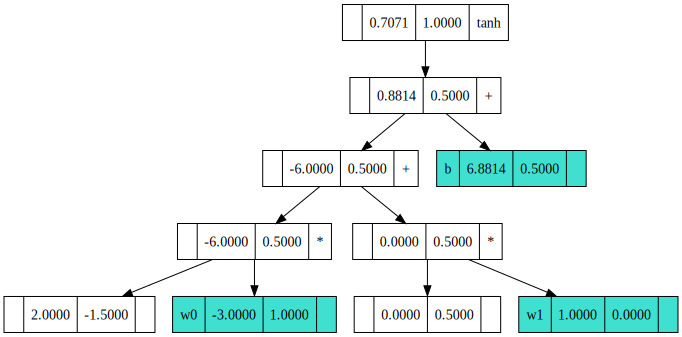

In [68]:
x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0,label='w0')
w2 = Value(1.0,label='w1')
b = Value(6.8813753870195432,label='b')
s = x1*w1 + x2*w2 + b
o = s.tanh()
o.backward()
draw(o)

In [69]:
class Nueron:
    def __init__(self, numinputs, label=''):
        self.w = [Value(random.uniform(-1, 1),
                        label=f'{label}.w{i}') for i in range(numinputs)]
        self.bias = Value(random.uniform(-1, 1), label=f'{label}.b')

    def __call__(self, inputs):
        out = sum([i*j for i, j in zip(self.w, inputs)], self.bias)
        return out.relu()

    def parameters(self):
        return self.w + [self.bias]

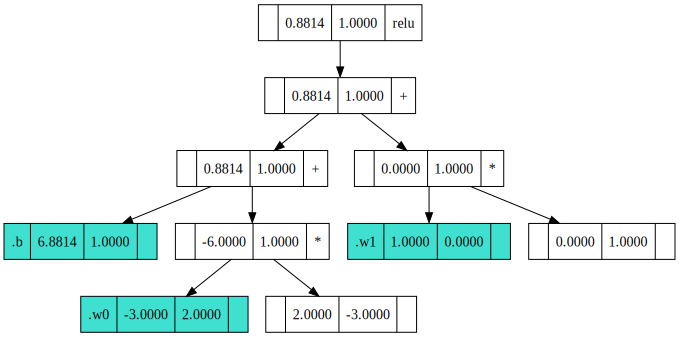

In [70]:
x = Nueron(2)
x.w[0].data = -3.0
x.w[1].data = 1.0
x.bias.data = 6.8813753870195432
output = x([2.0, 0.0])
output.backward()
draw(output)

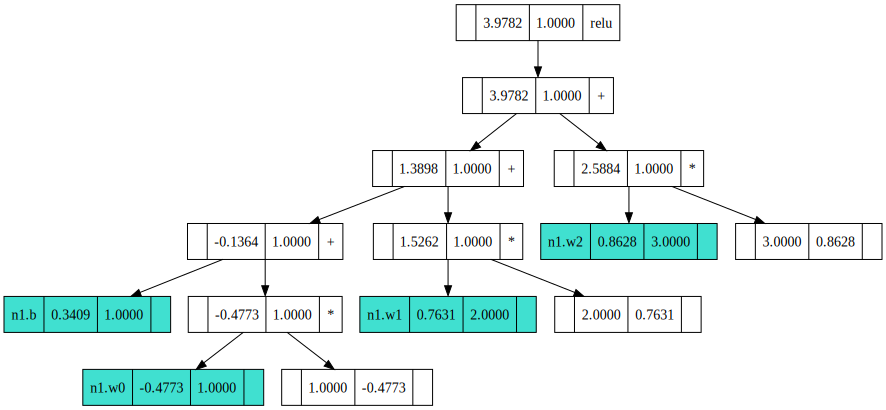

In [71]:
n = Nueron(3, label='n1')
out = n([1, 2, 3])
out.backward()
draw(out)

In [72]:
class Layer:
    def __init__(self, numinputs, numoutputs):
        self.neurons = [
            Nueron(numinputs, label=f"n{i}") for i in range(numoutputs)]

    def __call__(self, x):
        return [self.neurons[i](x) for i in range(len(self.neurons))]

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

In [73]:
l = Layer(3, 4)
l([1, 2, 3])
l.parameters()

[n0.w0|-0.0948|0.0000|,
 n0.w1|0.6181|0.0000|,
 n0.w2|-0.3490|0.0000|,
 n0.b|0.1839|0.0000|,
 n1.w0|0.6337|0.0000|,
 n1.w1|0.0656|0.0000|,
 n1.w2|-0.8959|0.0000|,
 n1.b|0.1745|0.0000|,
 n2.w0|0.4229|0.0000|,
 n2.w1|0.9151|0.0000|,
 n2.w2|0.9410|0.0000|,
 n2.b|-0.1735|0.0000|,
 n3.w0|0.6564|0.0000|,
 n3.w1|0.1387|0.0000|,
 n3.w2|-0.7583|0.0000|,
 n3.b|0.0667|0.0000|]

In [74]:
class Net:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

    def __init__(self, numinputs, numoutputs):
        self.numinputs = numinputs
        self.numoutputs = numoutputs
        self.layers = []
        z = [numinputs] + numoutputs
        for i in range(len(z)-1):
            self.layers.append(Layer(z[i], z[i+1]))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) == 1 else x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [86]:
net = Net(3, [4, 4, 1])

xs = [[Value(2.0), Value(3.0), Value(-1.0)],
      [Value(3.0), Value(-1.0), Value(0.5)],
      [Value(0.5), Value(1.0), Value(1.0)],
      [Value(1.0), Value(1.0), Value(-1.0)]]

ys = [Value(1.0), Value(-1.0), Value(-1.0), Value(1.0)]

for epoch in range(20):
    yPred = [net(x) for x in xs]
    loss = sum((yt - yp)**2 for yt, yp in zip(ys, yPred))
    print(f'epoch {epoch}: loss {loss.data}')
    net.zero_grad()
    loss.backward()
    for parameter in net.parameters():
        parameter.data -= 0.05 * parameter.grad

print(loss)
#draw(loss)

epoch 0: loss 0.20767005818923145
epoch 1: loss 0.038189526113971396
epoch 2: loss 0.012972121093454312
epoch 3: loss 0.005230503942685213
epoch 4: loss 0.002486210243824241
epoch 5: loss 0.0013753451756828722
epoch 6: loss 0.0007775671825196045
epoch 7: loss 0.0004438679501702138
epoch 8: loss 0.0002551623487185608
epoch 9: loss 0.00014744317996826073
epoch 10: loss 8.55270334535283e-05
epoch 11: loss 4.9754698329032037e-05
epoch 12: loss 2.9007349879438693e-05
epoch 13: loss 1.6939303934564408e-05
epoch 14: loss 9.904316072104762e-06
epoch 15: loss 5.796491313761126e-06
epoch 16: loss 3.3948422385079557e-06
epoch 17: loss 1.9893597526201866e-06
epoch 18: loss 1.1662450628085748e-06
epoch 19: loss 6.839210708882263e-07
|0.0000|1.0000|+


In [76]:
import torch
x1 = torch.tensor([2.0], dtype=float, requires_grad=True)
x2 = torch.tensor([0.0], dtype=float, requires_grad=True)
w1 = torch.tensor([-3.0], dtype=float, requires_grad=True)
w2 = torch.tensor([1.0], dtype=float, requires_grad=True)
b = torch.tensor([6.8813753870195432], dtype=float, requires_grad=True)
s = x1*w1 + x2*w2 + b
o = s.tanh()
o.backward()
print(f"{o.item()=},{x1.grad.item()=},{x2.grad.item()=}, {w1.grad.item()=},{w2.grad.item()=}")

o.item()=0.7071076811854019,x1.grad.item()=-1.499996181625812,x2.grad.item()=0.49999872720860405, w1.grad.item()=0.9999974544172081,w2.grad.item()=0.0
